# Building a Neural Network using Keras

### Task

We would like to build a predictive model to help us determine the median value of homes in a metropolitan city.

### Input features
1. Crime_rate: per capita crime rate by town
2. Mountain_view: 1 if property has mountain views; 0 otherwise
3. Avg_room_num: average number of rooms per dwelling
4. Low_stat: % of lower income individuals in area

### Target variable
1. Value: Median value of homes in $1000's

Our target variable is a numeric, continuous variable. Therefore, this is a regression problem and we will build a neural network regressor.

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

!pip install keras
 
from keras.models import Sequential
from keras.layers import Dense

In [2]:
# # Mounting notebook (for Google Colab users)
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
# df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Housing_dataset.csv')
df = pd.read_csv('Housing_dataset.csv')
df.head()

,Crime_rate,Mountain_view,Avg_room_num,Low_stat,Value
0,0.00632,No,6.575,4.98,24.0
1,0.02731,No,6.421,9.14,21.6
2,0.02729,No,7.185,4.03,34.7
3,0.03237,No,6.998,2.94,33.4
4,0.06905,No,7.147,5.33,36.2


In [25]:
df.describe()

,Crime_rate,Avg_room_num,Low_stat,Value
count,506.000000,506.000000,506.000000,506.000000
mean,3.613524,6.284634,12.653063,22.532806
std,8.601545,0.702617,7.141062,9.197104
min,0.006320,3.561000,1.730000,5.000000
25%,0.082045,5.885500,6.950000,17.025000
50%,0.256510,6.208500,11.360000,21.200000
75%,3.677083,6.623500,16.955000,25.000000
max,88.976200,8.780000,37.970000,50.000000


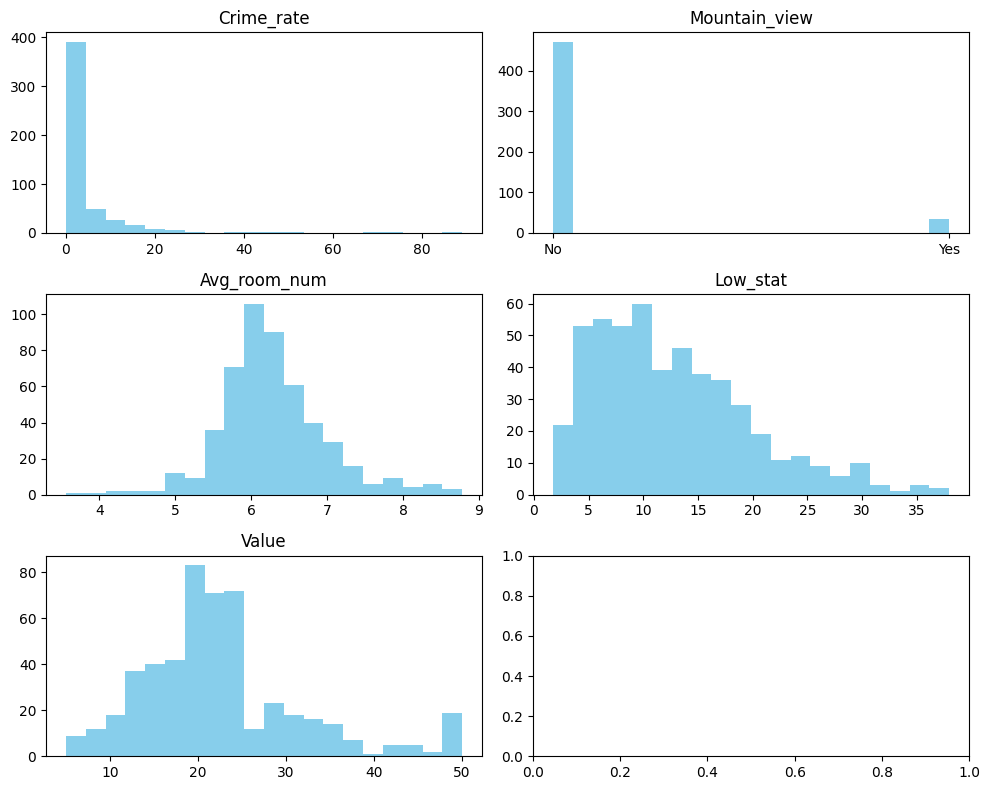

In [26]:
# Create columns variable to store column names
columns = df.columns.tolist()

fig, axs = plt.subplots(3, 2, figsize = (10,8))
axs = axs.flatten() # for easy iteration

# Plot histograms in subplots
for i, column in enumerate(columns):
  axs[i].hist(df[column], bins = 20, color = 'skyblue')
  axs[i].set_title(column)

plt.tight_layout()

In [27]:
# Unique entries for mountain view categorical variable
df['Mountain_view'].unique()

array(['No', 'Yes'], dtype=object)

In [28]:
# Encoding cat variable
df['Mountain_view'] = df['Mountain_view'].map({'No': 0, 'Yes': 1})

We see that the distribution of our features is mostly Gaussian, so we will apply z-score normalisation using StandardScaler(). We must be careful to not transform the categorical feature (Mountain_view) and the target variable (Value).

In [29]:
# Drop target and categorical variables
features = df.drop(columns = ['Mountain_view', 'Value'])

# Initialise StandardScaler
scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

# Create DataFrame containing scaled features
scaled_df = pd.DataFrame(scaled_features, columns = features.columns)

# Concatenate scaled features DataFrame with Mountain_view and Value columns
scaled_df['Mountain_view'] = df['Mountain_view']
scaled_df['Value'] = df['Value']
scaled_df.head()

,Crime_rate,Avg_room_num,Low_stat,Mountain_view,Value
0,-0.419782,0.413672,-1.075562,0,24.0
1,-0.417339,0.194274,-0.492439,0,21.6
2,-0.417342,1.282714,-1.208727,0,34.7
3,-0.416750,1.016303,-1.361517,0,33.4
4,-0.412482,1.228577,-1.026501,0,36.2


Text(0.5, 1.0, 'Heatmap')

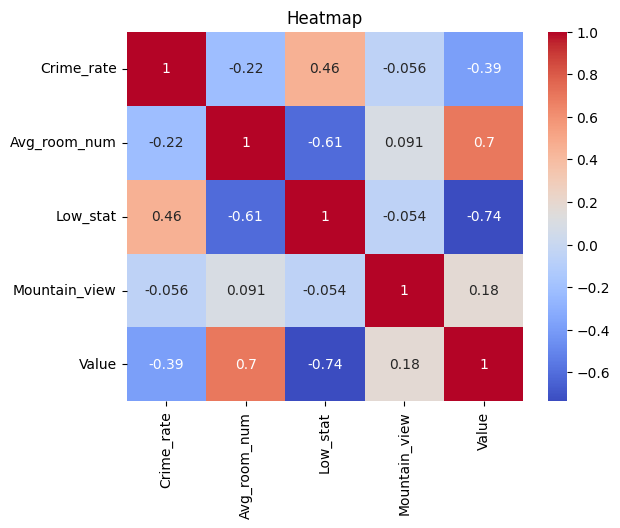

In [30]:
sns.heatmap(scaled_df.corr(), annot = True, cmap = 'coolwarm')
plt.title('Heatmap')

In [31]:
# Independent and dependent variables
X = df[['Crime_rate', 'Avg_room_num', 'Low_stat', 'Mountain_view']]
y = df['Value']

# Train, test and validation set split
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.4, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 42)

 - Training set: 60% of the original data
 - Validation set: 20% of the original data
 - Test set: 20% of the original data

We will use a Random Forest regressor model to obtain feature importance plots which will help us determine which features are worth keeping.

In [11]:
# Create Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)

# Train the RF regressor
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Text(0, 0.5, 'Features')

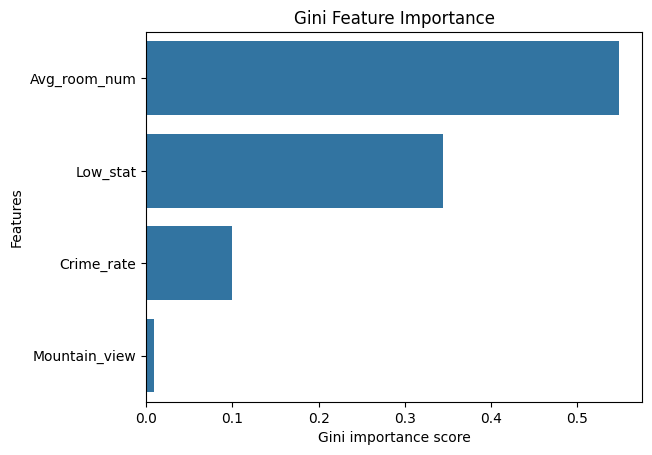

In [32]:
#Finding the important features using the built-in Gini importance
importances = rf_reg.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': scaled_df.columns.tolist()[:4], 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)

# Creating a seaborn bar plot
sns.barplot(x=feature_imp_df['Gini Importance'],y=feature_imp_df['Feature'],data=feature_imp_df)
plt.title("Gini Feature Importance")
plt.xlabel("Gini importance score")
plt.ylabel("Features")


Text(0, 0.5, 'Features')

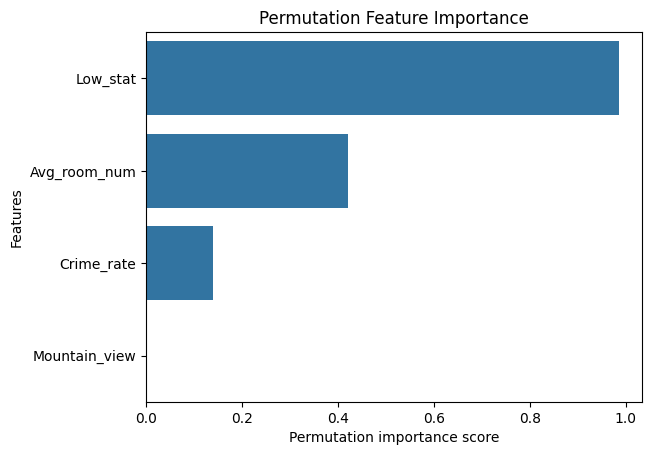

In [33]:
# Permutation feature importance
result = permutation_importance(rf_reg, X_val, y_val, n_repeats = 10, random_state = 42, n_jobs = -1)
perm_imp_df = pd.DataFrame({'Feature': scaled_df.columns.tolist()[:4], 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending = False)

# Creating a seaborn bar plot
sns.barplot(x = perm_imp_df['Permutation Importance'], y = perm_imp_df['Feature'], data = perm_imp_df)
plt.title("Permutation Feature Importance")
plt.xlabel("Permutation importance score")
plt.ylabel("Features")

The Gini importance score and permutation importance score results both show that Mountain_view is the least important feature in our dataset.

In [34]:
# drop the least important feature from X_train, X_val and X_test
X_train_imp = X_train.drop(['Mountain_view'], axis=1)
X_val_imp = X_val.drop(['Mountain_view'], axis=1)
X_test_imp = X_test.drop(['Mountain_view'], axis=1)

We now build our neural network. Because we will be testing out different combinations of hyperparameters to determine the optimal values to use, we will create a function that builds the neural network. We will simply call the function, build_neural_network(), for each iteration where we want to test out a different hyperparameter combination.

In [35]:
# Function to create the model
def build_neural_network(neurons=1, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=3, activation=activation))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

The two hyperparameters we will test out in this example are the number of neurons in the single hidden layer and which activation function to use in the hidden layer.

In [36]:
# Hyperparameter grid to test out combinations of neurons and activation functions
param_grid = {
    'neurons': [5, 10, 15, 20, 25, 30, 35],
    'activation': ['relu', 'tanh', 'sigmoid']
}

In [37]:
# Initialise variables to track the best model
best_rmse = float('inf')
best_params = None
best_model = None

Implementing grid search logic to determine the best combination of hyperparameters for our problem. Alternatively, you can use the KerasRegressor Wrapper and grid search using GridSearchCV. This approach is more efficient (feel free to challenge yourself with learning and implementing this). The code below implements the same logic manually.

In [38]:
# Iterate over the hyperparameter grid
for neurons in param_grid['neurons']:
    for activation in param_grid['activation']:  # The nested for loops allow us to test out all combinations
        print(f"Training model with {neurons} neurons and {activation} activation")

        model = build_neural_network(neurons = neurons, activation = activation)
        model.fit(X_train_imp, y_train, epochs=100, batch_size=10, verbose=0)

        y_val_pred = model.predict(X_val_imp) # We set aside the validation set so we can test model performance during training

        mse = mean_squared_error(y_val, y_val_pred)

        rmse = np.sqrt(mse)

        # Print the mean cross-validation score for the current hyperparameters
        print(f"RMSE: {rmse}")

        # Update the best model if the current one is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = {'neurons': neurons, 'activation': activation}
            best_model = model

Training model with 5 neurons and relu activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 4.8275920022096255
Training model with 5 neurons and tanh activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 10.234061556688712
Training model with 5 neurons and sigmoid activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 11.116506552660029
Training model with 10 neurons and relu activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 5.046881102815709
Training model with 10 neurons and tanh activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 7.501646365008603
Training model with 10 neurons and sigmoid activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 8.200650979190517
Training model with 15 neurons and relu activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 4.369575833697736
Training model with 15 neurons and tanh activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 5.713160556940632
Training model with 15 neurons and sigmoid activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE: 7.0209847262490275
Training model with 20 neurons and relu activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE: 4.987571425661558
Training model with 20 neurons and tanh activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 5.953888582771823
Training model with 20 neurons and sigmoid activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
RMSE: 7.14284936628867
Training model with 25 neurons and relu activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE: 4.4800083559349515
Training model with 25 neurons and tanh activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 5.077010172460314
Training model with 25 neurons and sigmoid activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
RMSE: 5.901183571965696
Training model with 30 neurons and relu activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE: 4.305089645677403
Training model with 30 neurons and tanh activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
RMSE: 4.8851157376061005
Training model with 30 neurons and sigmoid activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
RMSE: 5.332790349885792
Training model with 35 neurons and relu activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
RMSE: 4.219671342928506
Training model with 35 neurons and tanh activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
RMSE: 4.684710758587804
Training model with 35 neurons and sigmoid activation


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE: 5.348441371649159


In [39]:
# Print the best hyperparameters and the corresponding score
print(f"Best Score: {best_rmse} with parameters: {best_params}")

Best Score: 4.219671342928506 with parameters: {'neurons': 35, 'activation': 'relu'}


In [40]:
# Evaluate the best model on the test data - we only use the test set when we are satisfied with our model based on its performance on the validation set
y_pred = best_model.predict(X_test_imp)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on test data: {rmse}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE on test data: 4.609260416781897


In [42]:
R_sq = r2_score(y_test, y_pred)
print("R-squared is ", round(R_sq*100), "%")

R-squared is  75 %


The R-squared is ~75%. When we fitted a Multiple Linear Regression model for the same problem in the Task 18 Walkthrough, our R-squared was 52%. Our Neural Network has outperfomed the Linear Regression model.

Our neural network can still be improved. We have other hyperparameters (such as the learning rate, number of epochs, optimiser type and the number of hidden layers) and techniques (such as regularisation and weight initialisation strategies) that we can implement to make this model even more powerful.